# Project: Image Classification with Multilayer Neural Network

## Introduction

In this project, our primary aim is to develop a multilayer neural network capable of classifying images into their corresponding categories. We will be using the **CIFAR100** dataset, which is a large-scale dataset containing a wide variety of visual objects.

## Team Members

This project is a collaborative effort between the following team members:

1. **Ahmed Hisham Fathy Hassabou**
   - Student ID: 19P4007

2. **Eslam Elhusseini**
   - Student ID: 19P9651

## Project Goals

Our project can be broken down into several key objectives:

1. **Data Collection and Preparation:**
   - We will select at least 500 visual objects from the ImageNet dataset and construct a suitable dataset for each object, ensuring an appropriate number of images per category.
   - The data will be divided into training (70%), validation (15%), and testing (15%) sets.

2. **Feature Extraction:**
   - We will explore various image feature extraction techniques, such as Histogram of Oriented Gradients (HoG) and others, to represent our images effectively.

3. **Data Normalization:**
   - We will normalize our data by subtracting the mean and dividing by the standard deviation at each dimension. The normalized data will be visualized for further analysis.

4. **Neural Network Design:**
   - Using TensorFlow, we will design a multilayer neural network architecture tailored for image classification.

5. **Hyperparameter Tuning:**
   - We will employ cross-validation to determine the optimal number of hidden layers and nodes per layer in our neural network.

6. **Training and Visualization:**
   - The training process, including loss vs. iterations, will be visualized to monitor the model's learning progress.

7. **Model Evaluation:**
   - We will assess the performance of our model on the test set and report the best accuracy achieved.

8. **Comparison with AutoKeras:**
   - We will compare our results with a model generated by AutoKeras for our dataset.

## Project Structure

Our project will be structured into the following phases:

### 1. Data Collection and Preparation
   - We will select and construct a suitable dataset from ImageNet.

### 2. Feature Extraction and Normalization
   - Explore and implement feature extraction methods.
   - Normalize the data and visualize it.

### 3. Neural Network Design
   - Design a multilayer neural network using TensorFlow/Keras.

### 4. Hyperparameter Tuning
   - Utilize cross-validation to determine the best architecture.

### 5. Training and Visualization
   - Train the model and visualize the training process.

### 6. Model Evaluation
   - Assess the model's accuracy on the test set.

### 7. Comparison with AutoKeras
   - Compare our model's performance with AutoKeras-generated models.

## Conclusion

By the end of this project, we aim to have a well-trained multilayer neural network for image classification. We will also gain insights into the impact of hyperparameters and the performance of various feature extraction techniques. This knowledge will contribute to our understanding of deep learning for image classification tasks.

Let's get started on this exciting image classification journey!


In [ ]:
# Step 1: Import necessary libraries

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from skimage import exposure
from keras.models import Model
from keras.layers import Dense
from skimage.feature import hog
from sklearn.cluster import KMeans
from keras.models import Sequential
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.vgg19 import VGG19, preprocess_input

In [ ]:
# Step 2: Load the CIFAR-100 dataset

# Variables to be used
num_classes = 100        # Change this number as needed
images_per_class = 600   # Change this number as needed

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

# Get the number of classes/categories
num_classes = len(np.unique(y_train))
print(num_classes)

print(x_test.shape)

100
(10000, 32, 32, 3)


In [ ]:
# Step 3: Extract Features

# Define parameters for HoG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

def extract_hog_features(images):
    features_list = []
    for img in images:

        # Convert the image to grayscale if it's not already
        if img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Compute HoG features
        features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm='L2-Hys')

        features_list.append(features)

    return np.array(features_list)


print(x_train.shape)

# Extract HoG features for each split
x_train_features = extract_hog_features(x_train)
x_test_features = extract_hog_features(x_test)

# Convert the label lists to NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Save the split data and labels to files
np.save('/content/x_train_features.npy', x_train_features)
np.save('/content/x_test.npy', x_test_features)

np.save('/content/y_train.npy', y_train)
np.save('/content/y_test.npy', y_test)

(50000, 32, 32, 3)


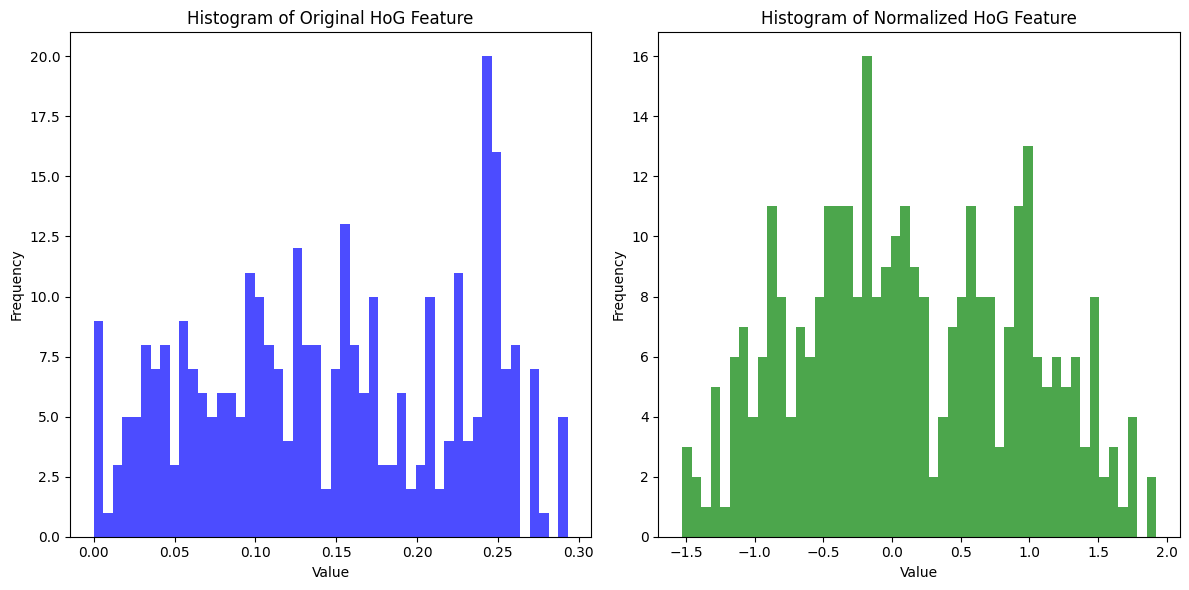

In [ ]:
# Step 5: Normalize HoG Features
scaler = StandardScaler()

# Fit the scaler on the HoG features and then transform the features
x_train_features_normalized = scaler.fit_transform(x_train_features)
x_test_features_normalized = scaler.transform(x_test_features)

# Plot the histogram for the original HoG feature
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Histogram of Original HoG Feature')
plt.hist(x_train_features[0], bins=50, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot the histogram for the normalized HoG feature
plt.subplot(1, 2, 2)
plt.title('Histogram of Normalized HoG Feature')
plt.hist(x_train_features_normalized[0], bins=50, color='green', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Step 5: Tuning for best hidden layers and nodes number

# Define a function to create a neural network model
def create_model(num_hidden_layers=1, num_nodes=64, input_shape=(324,)):
    model = Sequential()
    model.add(Dense(num_nodes, activation='relu', input_shape=input_shape))

    for _ in range(num_hidden_layers - 1):
        model.add(Dense(num_nodes, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create a KerasClassifier for GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define hyperparameters to search
param_grid = {
    'num_hidden_layers': [1, 2, 3],
    'num_nodes': [64, 128, 256]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(x_train_features_normalized, y_train)

# Print the best configuration and its performance
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-17-5cff0f4557d2>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


Best: 0.216140 using {'num_hidden_layers': 1, 'num_nodes': 128}


In [ ]:
best_num_hidden_layers = grid_result.best_params_["num_hidden_layers"]  # Replace with the best value you found
best_num_nodes = grid_result.best_params_["num_nodes"]

print(best_num_hidden_layers)

print(best_num_nodes)

1
128


Epoch 1/100
1250/1250 - 5s - loss: 3.7905 - accuracy: 0.1438 - val_loss: 3.5224 - val_accuracy: 0.1877 - 5s/epoch - 4ms/step
Epoch 2/100
1250/1250 - 3s - loss: 3.3058 - accuracy: 0.2213 - val_loss: 3.4382 - val_accuracy: 0.2008 - 3s/epoch - 2ms/step
Epoch 3/100
1250/1250 - 3s - loss: 3.1511 - accuracy: 0.2494 - val_loss: 3.4101 - val_accuracy: 0.2122 - 3s/epoch - 2ms/step
Epoch 4/100
1250/1250 - 3s - loss: 3.0463 - accuracy: 0.2689 - val_loss: 3.4028 - val_accuracy: 0.2157 - 3s/epoch - 2ms/step
Epoch 5/100
1250/1250 - 4s - loss: 2.9715 - accuracy: 0.2857 - val_loss: 3.4159 - val_accuracy: 0.2143 - 4s/epoch - 3ms/step
Epoch 6/100
1250/1250 - 3s - loss: 2.9141 - accuracy: 0.2926 - val_loss: 3.4241 - val_accuracy: 0.2168 - 3s/epoch - 2ms/step
Epoch 7/100
1250/1250 - 3s - loss: 2.8627 - accuracy: 0.3015 - val_loss: 3.4338 - val_accuracy: 0.2163 - 3s/epoch - 2ms/step
Epoch 8/100
1250/1250 - 3s - loss: 2.8237 - accuracy: 0.3068 - val_loss: 3.4607 - val_accuracy: 0.2143 - 3s/epoch - 2ms/step


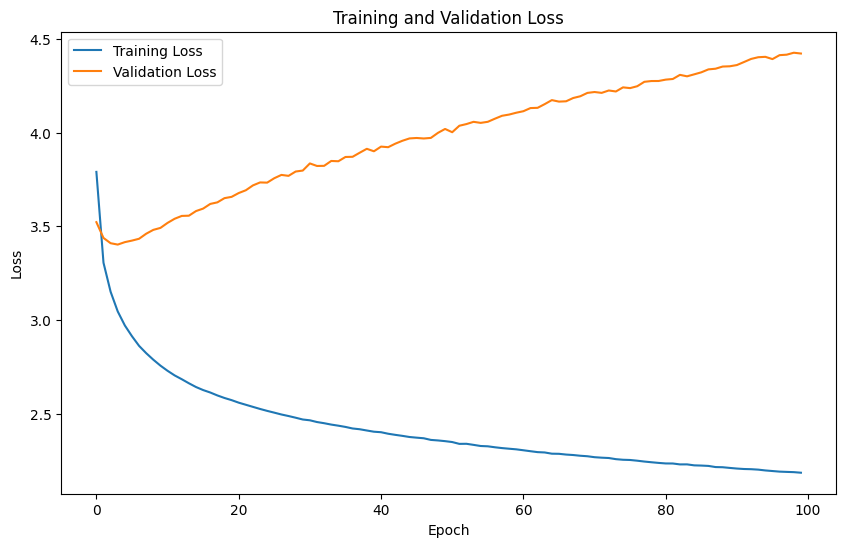

313/313 [==============================] - 1s 2ms/step - loss: 4.3582 - accuracy: 0.1916
Test accuracy: 19.16%


In [ ]:
# Step 6: Build the neural network for normalized HoG features
# Define the model with the best hyperparameters
     # Replace with the best value you found

# Create the model
final_model = create_model(num_hidden_layers=best_num_hidden_layers, num_nodes=best_num_nodes)

# Compile the model
final_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Training parameters
epochs = 100  # You can adjust the number of epochs
batch_size = 32

# Train the model and record the training history
history = final_model.fit(x_train_features_normalized, y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_split = 0.2,
                          verbose=2)

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


# Evaluate the model on the test data
test_loss, test_accuracy = final_model.evaluate(x_test_features_normalized, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')